In [44]:
import scanpy as sc
from pathlib import Path
import pandas as pd
import os
import re
import numpy as np
import anndata as ad
from tqdm import tqdm
import squidpy as sq
from jax.config import config

config.update("jax_enable_x64", True)

from joblib import Parallel, delayed
import squidpy as sq
import scanpy as sc
from anndata import AnnData
from scipy.sparse import csr_matrix

%load_ext autoreload
%autoreload 2
%load_ext lab_black

path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [45]:
import yaml

with open(
    "/home/icb/giovanni.palla/code/moscot_benchmarks/experiments/space/mapping/method_benchmark/config.yaml",
    "r",
) as stream:
    out = yaml.safe_load(stream)
datasets = out["grid"]["dataset"]["options"]
n_cells = []
for d in datasets:
    n_cells.append(sc.read(path_read / f"dataset{d}_sp.h5ad").shape[0])

In [46]:
np.random.normal(size=(20, 2)).mean()

-0.024305217061012206

In [47]:
df = pd.DataFrame({"dataset": datasets, "n_cells": n_cells})
df.sort_values(by="n_cells")

dataset  n_cells
0        30     2064
1        37     2125
2        45     2177
3        26     2425
4        22     2432
5        33     3024
6        32     3024
7        14     3039
8         3     3585
9        20     4784
10       21     4895
11       41     6000
12        1     8425
13       39     9852

In [48]:
df.sort_values(by="n_cells").dataset.to_list()

[30, 37, 45, 26, 22, 33, 32, 14, 3, 20, 21, 41, 1, 39]

In [49]:
datasets = os.listdir(path_read)

In [51]:
from pathlib import Path

path_data = "/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data"
path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/data/DataUpload")
dataset = 32  # 14 is drosophila
seed = 42
adata_sp = ad.read(Path(path_data) / f"dataset{dataset}_sp.h5ad")
rng = np.random.default_rng(seed)
if "highly_variable" in adata_sp.var.columns:
    adata_sp = adata_sp[:, adata_sp.var.highly_variable].copy()
    n_genes = 100
else:
    n_genes = 10

# adata_sp_a = sc.pp.subsample(adata_sp, fraction=0.5, copy=True, random_state=seed)
# adata_sp_a = adata_sp.copy()
# adata_sp_b = adata_sp[~np.in1d(adata_sp.obs_names, adata_sp_a.obs_names)].copy()
adata_sp_b = adata_sp.copy()
sc_count = pd.read_csv(
    path_read / f"Dataset{dataset}" / "scRNA_count.txt", sep="\t", header=0, index_col=0
).T
adata_sp_a = AnnData(csr_matrix(sc_count.to_numpy()), dtype=sc_count.to_numpy().dtype)
adata_sp_a.var_names = sc_count.columns.tolist()
sc.pp.filter_cells(adata_sp_a, min_counts=10)
sc.pp.filter_genes(adata_sp_a, min_counts=2)
adata_sp_a.layers["counts"] = adata_sp_a.X.copy()
if adata_sp_a.shape[1] > 5000:
    sc.pp.highly_variable_genes(
        adata_sp_a, flavor="seurat_v3", n_top_genes=2000, subset=True
    )
sc.pp.normalize_total(adata_sp_a)
sc.pp.log1p(adata_sp_a)

intersect_var = list(set(adata_sp_a.var_names).intersection(set(adata_sp_b.var_names)))

# adata_sp_a = adata_sp_a[:, intersect_var].copy()
adata_sp_b = adata_sp_b[:, intersect_var].copy()

test_var = rng.choice(adata_sp_b.var_names, n_genes, replace=False).tolist()
# if "eve" is not test_var:
#     test_var.append("eve")
train_var = adata_sp_b.var_names[~np.in1d(adata_sp_b.var_names, test_var)].tolist()
true_df = sc.get.obs_df(adata_sp_b, keys=test_var)

# adata_sp_a_train = adata_sp_a[:, train_var].copy()
adata_sp_b_train = adata_sp_b[:, train_var].copy()

sc.tl.pca(adata_sp_b_train)
sc.tl.pca(adata_sp_a)
# adata_sp_a.obsm["X_pca"] = adata_sp_a_train.obsm["X_pca"].copy()

In [52]:
adata_sc = adata_sp_a
adata_sp_train = adata_sp_b_train

In [126]:
params = {"epsilon": 1e-5, "alpha": 0.3}
epsilon, alpha = params["epsilon"], params["alpha"]

In [127]:
from moscot.problems.space import MappingProblem

prob = MappingProblem(adata_sc=adata_sc, adata_sp=adata_sp_train)
prob = prob.prepare(
    sc_attr={"attr": "obsm", "key": "X_pca"},
    sp_attr={"attr": "obsm", "key": "spatial"},
    var_names=adata_sp_train.var_names.values,
    callback="local-pca" if adata_sp_train.shape[1] > 100 else None,
    kwargs={"joint-space": True},
)

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  


In [128]:
print(
    prob.problems[("src", "tgt")].xy.shape,
    prob.problems[("src", "tgt")].xy.shape,
)

(3024, 3512) (3024, 3512)


In [110]:
prob = prob.solve(
    alpha=alpha,
    epsilon=epsilon,
    threshold=1e-8,
    max_iterations=100,
    tau_a=0.95,
    tau_b=1.0,
)
print(prob.solutions[list(prob.solutions.keys())[0]].converged)
print(prob.solutions[list(prob.solutions.keys())[0]].cost)

INFO     Solving problem OTProblem[stage='prepared', shape=(3024, 3512)].                                          
True
2.405419598239768


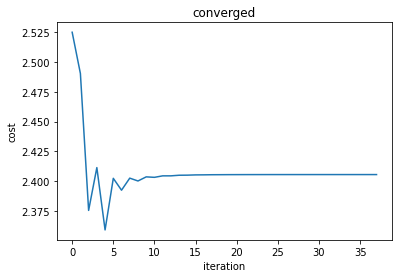

In [111]:
prob[("src", "tgt")].solution.plot_convergence()

In [112]:
adata_pred = prob.impute(var_names=true_df.columns.tolist(), device="cpu")
# pred_df = sc.get.obs_df(adata_pred, keys=true_df.columns.tolist())

In [113]:
adata_pred.var_names

Index(['Hs3st2', 'Ctxn3', 'Mgst3', 'Cd47', 'Rab3b', 'Gm17750', 'Ctsz',
       'Kcnip2', 'S100a16', 'Nts', 'Gng3', 'Sparcl1', 'Dlx1', 'Lhfpl3',
       'Pcdh18', 'Hmgcs2', 'Lsp1', 'Lamb1', 'Wls', 'Rgs3', 'Gadd45g', 'Rasd1',
       'Slc6a20a', 'Junb', 'Abi3bp', 'Csf1r', 'Tmem163', 'Fam19a1', 'Stxbp6',
       'Slc38a5', 'Nbl1', 'Igfbpl1', 'Rbp1', 'Asgr1', 'Dync1i1', 'Arpp21',
       'Myl9', 'Syndig1l', 'Ccl2', 'Myl12a', 'Tmsb4x', 'Gfap', 'H19',
       'Fam19a2', 'Shisa6', 'Ctnna1', 'Nrxn3', 'Snx7', 'Wwc1', 'Ube2c', 'Ntm',
       'Calb2', 'Avp', 'Trim10', 'Arpc1b', 'Slc24a2', 'Igf2', 'Mcam', 'Zfhx3',
       'Nid2', 'Rbms3', 'Syt6', 'Snca', 'Fos', 'Slc16a1', 'Cenpa', 'Id2',
       'Pcdh19', 'Uchl1', 'Neurod2', 'Pou3f1', 'Kitl', 'Dnaic2', 'Tppp3',
       'Gm11549', 'App', 'Aldh1a1', 'Camk2b', 'Enpp6', 'Penk', 'Tmtc4',
       'Slc30a3', 'Crmp1', 'Chrna3', 'Ldb2', 'Nrip3', 'Lhx2', 'Jup', 'Slc24a5',
       'Cpne4', 'Spp1', 'Islr2', 'Etl4', 'Mest', 'Akap12', 'Slc2a1', 'Fth1',
       'Slc29a1', 'C

In [114]:
pred_df = sc.get.obs_df(adata_pred, keys=adata_pred.var_names.tolist())

In [115]:
corr_pearson = pred_df.corrwith(true_df, method="pearson")
corr_spearman = pred_df.corrwith(true_df, method="spearman")

In [116]:
out = pd.concat([corr_pearson, corr_spearman], axis=1)
out.columns = ["pearson", "spearman"]

In [117]:
out.max(0)

pearson     0.142841
spearman    0.295811
dtype: float64

In [118]:
out.mean(0)

pearson    -0.030395
spearman   -0.004497
dtype: float64

In [119]:
out.sort_values(by="spearman")

pearson  spearman
Slc24a2 -0.057411 -0.235016
Mgst3   -0.173802 -0.234804
App     -0.318923 -0.234633
Cadps   -0.117027 -0.229716
Tmem163 -0.070742 -0.188754
...           ...       ...
Avp     -0.017320  0.185607
Rbp1     0.025837  0.202263
Abi3bp   0.134530  0.234078
Penk    -0.012227  0.234098
Dlx1     0.000244  0.295811

[100 rows x 2 columns]

In [120]:
adata_sp.var_names

Index(['Oprk1', 'Npbwr1', '3110035E14Rik', 'A830018L16Rik', 'Sulf1', 'Tfap2b',
       'Paqr8', '4933415F23Rik', 'Hs6st1', '2010300C02Rik',
       ...
       'Adra2a', 'Gucy2g', 'Tcf7l2', 'Habp2', 'Atrnl1', 'Gfra1', 'Eno4',
       'Slc18a2', 'E330013P04Rik', 'mt-Nd6'],
      dtype='object', length=2000)

In [121]:
adata_pred.obsm["spatial"] = adata_sp_b.obsm["spatial"].copy()

In [122]:
# adata_sp.obsm["spatial "] = adata_sp.obsm["spatial"][:, [0, 2]]
# adata_pred.obsm["spatial "] = adata_pred.obsm["spatial"][:, [0, 2]]

In [123]:
adata_pred.var_names

Index(['Hs3st2', 'Ctxn3', 'Mgst3', 'Cd47', 'Rab3b', 'Gm17750', 'Ctsz',
       'Kcnip2', 'S100a16', 'Nts', 'Gng3', 'Sparcl1', 'Dlx1', 'Lhfpl3',
       'Pcdh18', 'Hmgcs2', 'Lsp1', 'Lamb1', 'Wls', 'Rgs3', 'Gadd45g', 'Rasd1',
       'Slc6a20a', 'Junb', 'Abi3bp', 'Csf1r', 'Tmem163', 'Fam19a1', 'Stxbp6',
       'Slc38a5', 'Nbl1', 'Igfbpl1', 'Rbp1', 'Asgr1', 'Dync1i1', 'Arpp21',
       'Myl9', 'Syndig1l', 'Ccl2', 'Myl12a', 'Tmsb4x', 'Gfap', 'H19',
       'Fam19a2', 'Shisa6', 'Ctnna1', 'Nrxn3', 'Snx7', 'Wwc1', 'Ube2c', 'Ntm',
       'Calb2', 'Avp', 'Trim10', 'Arpc1b', 'Slc24a2', 'Igf2', 'Mcam', 'Zfhx3',
       'Nid2', 'Rbms3', 'Syt6', 'Snca', 'Fos', 'Slc16a1', 'Cenpa', 'Id2',
       'Pcdh19', 'Uchl1', 'Neurod2', 'Pou3f1', 'Kitl', 'Dnaic2', 'Tppp3',
       'Gm11549', 'App', 'Aldh1a1', 'Camk2b', 'Enpp6', 'Penk', 'Tmtc4',
       'Slc30a3', 'Crmp1', 'Chrna3', 'Ldb2', 'Nrip3', 'Lhx2', 'Jup', 'Slc24a5',
       'Cpne4', 'Spp1', 'Islr2', 'Etl4', 'Mest', 'Akap12', 'Slc2a1', 'Fth1',
       'Slc29a1', 'C

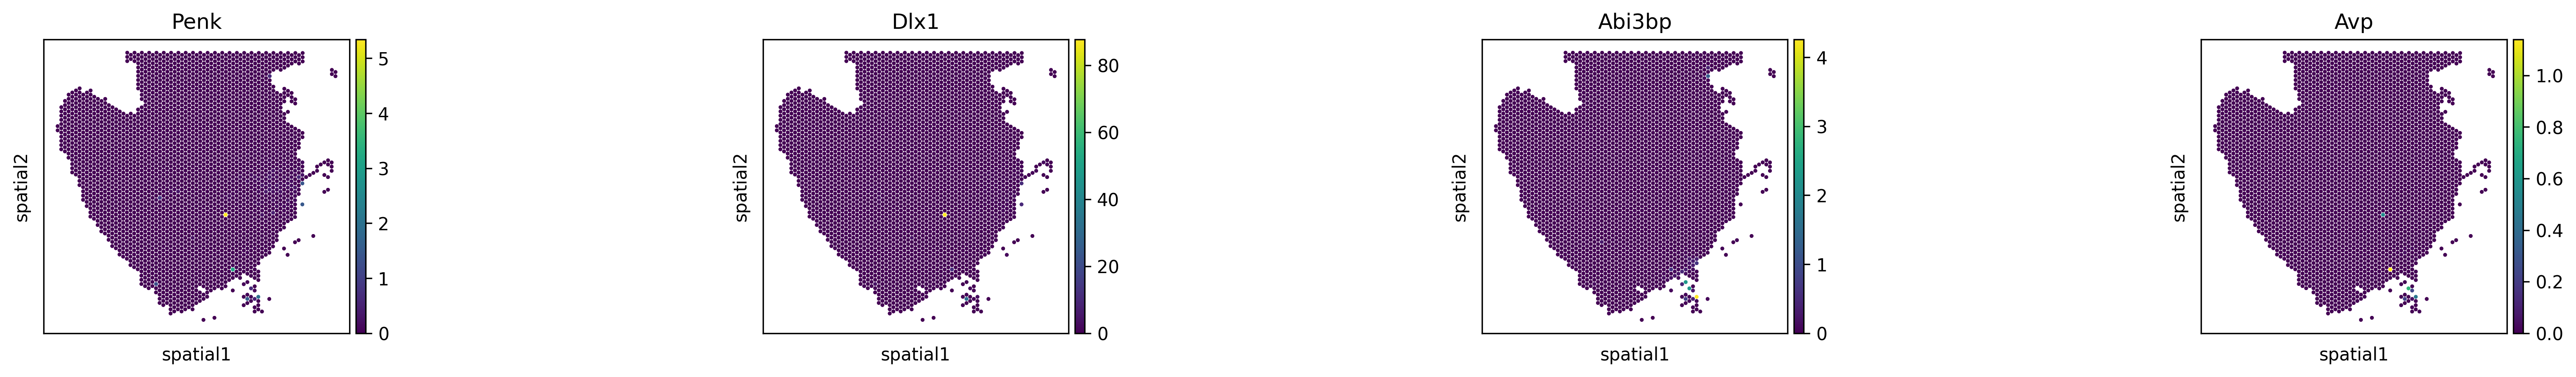

In [125]:
sq.pl.spatial_scatter(
    adata_pred,
    spatial_key="spatial",
    color=["Penk", "Dlx1", "Abi3bp", "Avp"],
    shape=None,
    size=5,
    dpi=300,
    figsize=(6, 3),
)

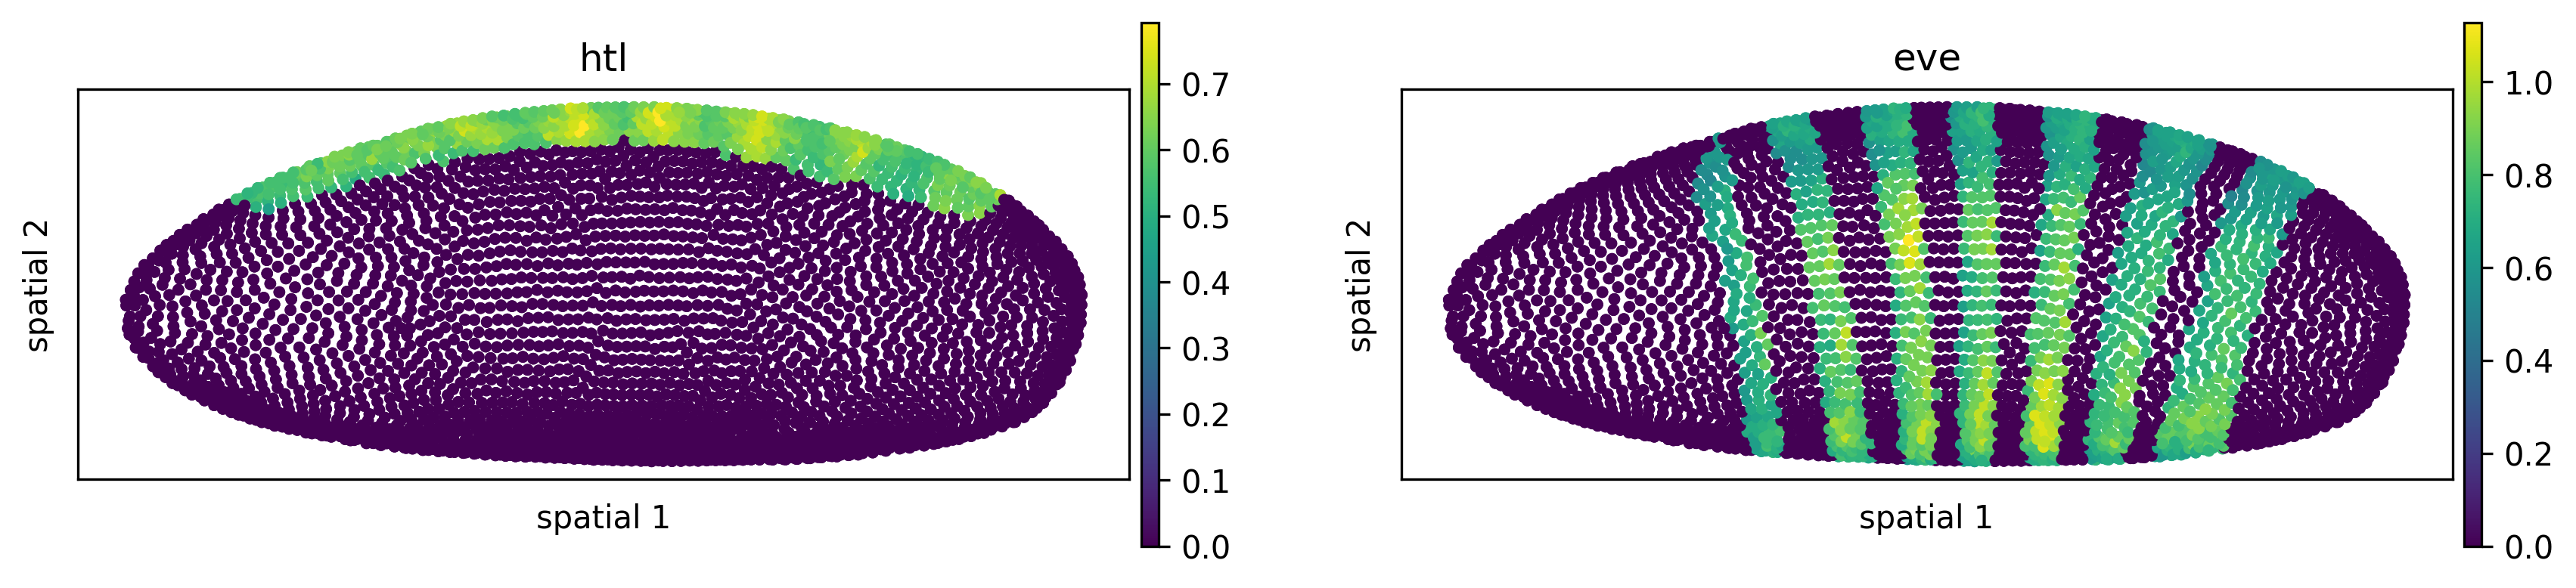

In [76]:
sq.pl.spatial_scatter(
    adata_sp,
    spatial_key="spatial ",
    color=["htl", "eve"],
    shape=None,
    size=30,
    dpi=300,
    figsize=(6, 3),
)

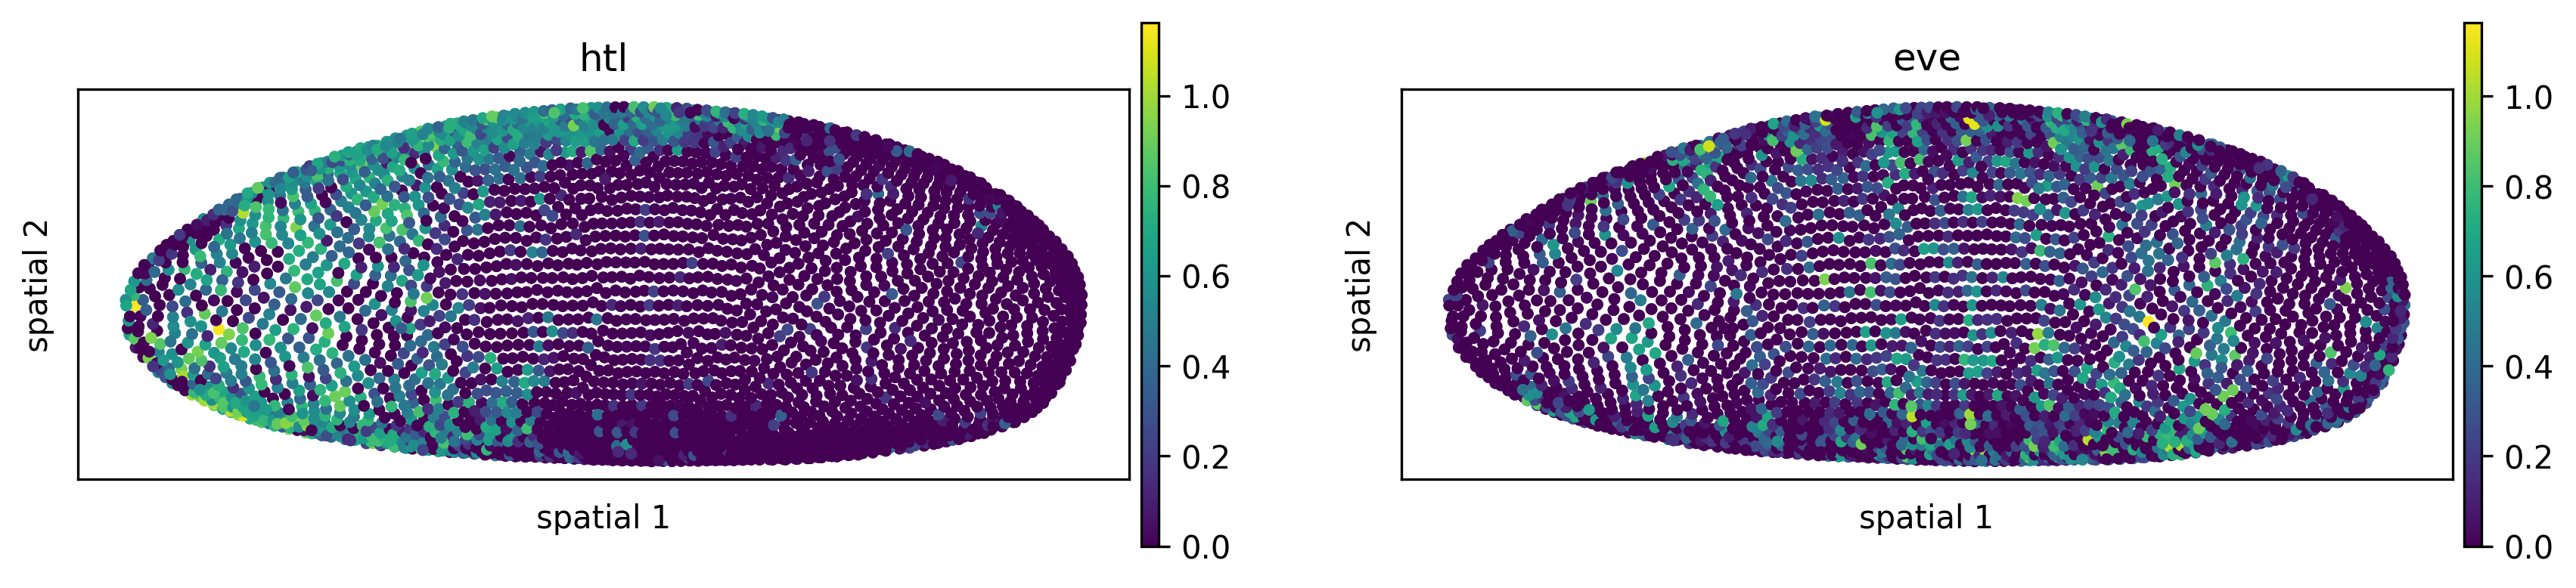

In [75]:
sq.pl.spatial_scatter(
    adata_pred,
    spatial_key="spatial ",
    color=["htl", "eve"],
    shape=None,
    size=30,
    dpi=300,
    figsize=(6, 3),
)

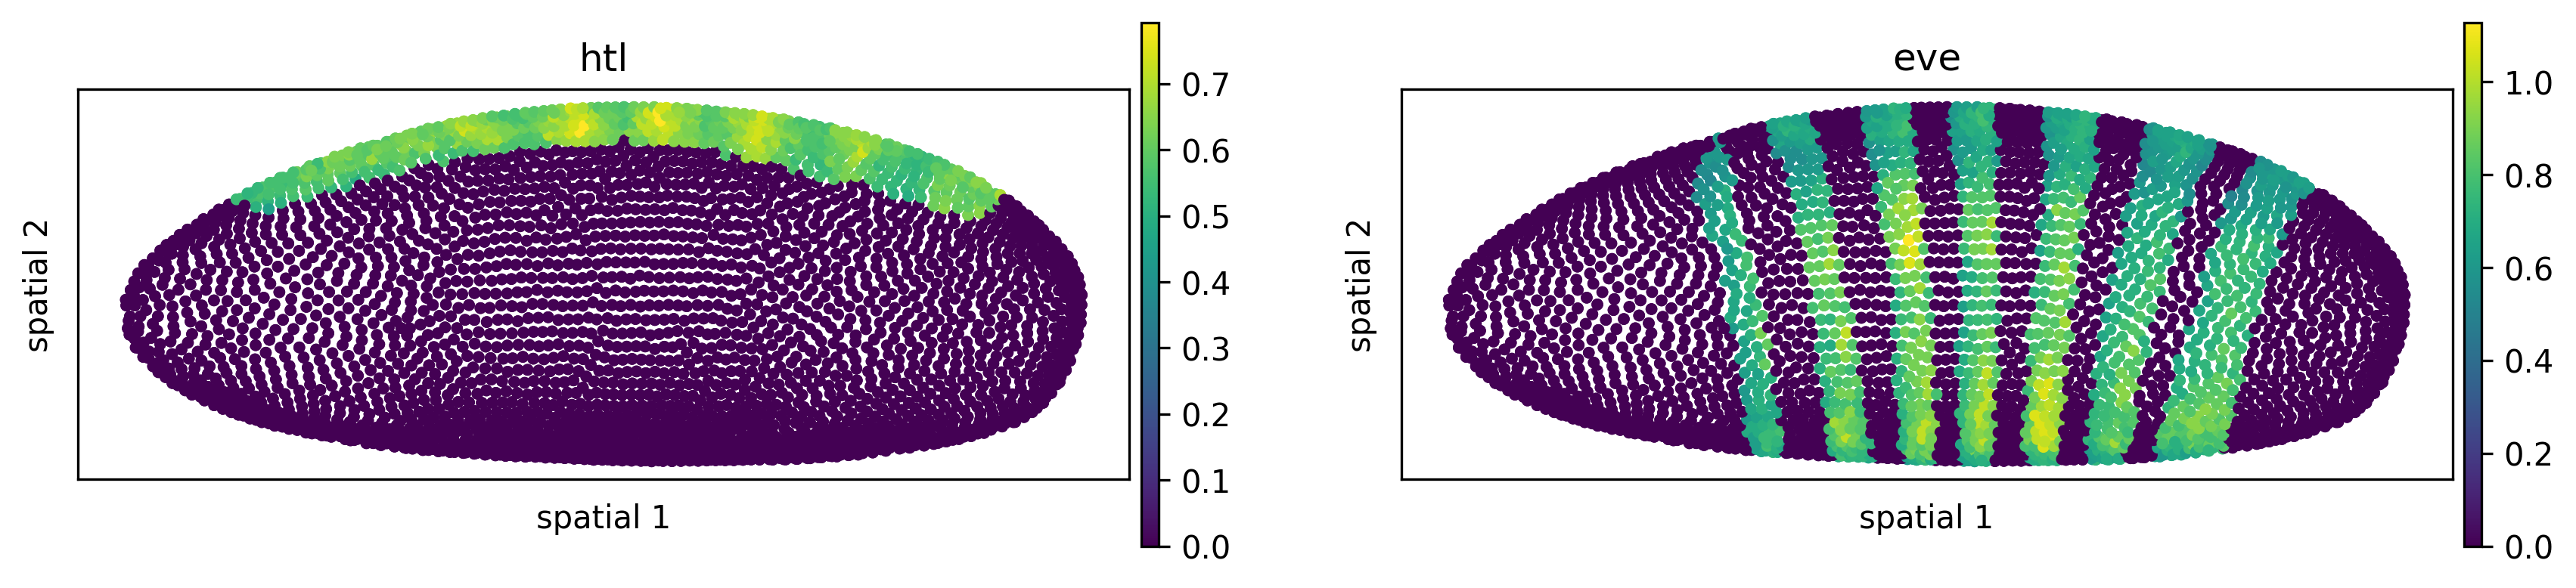

In [76]:
sq.pl.spatial_scatter(
    adata_sp,
    spatial_key="spatial ",
    color=["htl", "eve"],
    shape=None,
    size=30,
    dpi=300,
    figsize=(6, 3),
)

In [150]:
# sq.pl.spatial_scatter(adata_sp_b, color=["Esyt2"], shape=None)